# Main advantages of Hierarchical CLustering:
- Do not have to assume any particular number of clusters, any desired number of clusters can be obtained cuttin the endogram
- They may correspond to meaningful taxonomies: gerarchical classification of objects

## Two main types
1) Agglomerative: start with each poin as indivudual clustes and merge clustest while we have k clusters
2) Divisive: start with all-inclusive cluster and split while we have k clustes

In both cases we have to choose a distance measure and split/merge one cluster at a time, selecting the two clusters that have the minumum distance

## Inter-Cluster Distane
- MIN (single link): closest points in the two clusters
    - take strongly into account the contiguity so it can handle globular shapes but it is sentitive to noise
- MAX (complete link): farther points in the two clusters
    - less subsceptible to noise but tends to break large clusters and is biased towards globular ones
- Group average: mean of all possible distances between the point of the two clusters
    - good compromise between single and complete link, still a bit biased toward globular clusters
- Distance between centroids: distance between the centroids of the two clusters
- Ward's Method

In [29]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plot

In [30]:
df = pd.read_csv("./dataset/users_df_dataset_cleaned_with_indicators.csv")

As a first step, since we will work on numerical features we remove categorical/nominal? attributes 

In [31]:
df.drop(["user_id", "name", "lang", "bot", "created_at", "day_with_most_tweets"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   statuses_count                     11109 non-null  int64  
 1   account_age_in_days                11109 non-null  int64  
 2   number_of_tweets                   11109 non-null  int64  
 3   account_average_tweets_per_day     11109 non-null  float64
 4   avg_tweets_per_actual_day          11109 non-null  float64
 5   max_number_of_tweet_in_a_day       11109 non-null  int64  
 6   entropy_for_day                    11109 non-null  float64
 7   entropy_for_hour                   11109 non-null  float64
 8   entropy_for_minute                 11109 non-null  float64
 9   avg_hashtags                       11109 non-null  float64
 10  avg_text_length                    11109 non-null  float64
 11  avg_mentions                       11109 non-null  flo

Now we have to normalize the attributes to avoid bias given by the different range

In [32]:
scaler = StandardScaler()
transformed_array = scaler.fit_transform(df.values)
transformed_array.shape
#numpy array of array, each array rappresent a row of the dataframe

(11109, 21)

In the following lines we calculate the distace between all pairs of points and then we plot the dendrogram

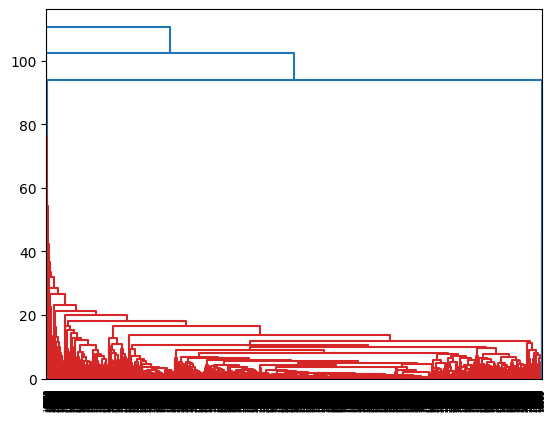

In [33]:
#Pairwise distances between observations in n-dimensional space.
data_dist = pdist(transformed_array, metric='euclidean')
# Perform hierarchical/agglomerative clustering.    
data_link = linkage(data_dist, method='complete', metric='euclidean')
# Plot the hierarchical clustering as a dendrogram.
res = dendrogram(data_link)

From this figure we see that the height of the "legs" starts to increase very fast after approximately 30 clusters.

For further investigations, in the next script we are going to compute the SSE for each possible clusteing from 2 to 200,
we expect that around K=30 the decreasing of the SSE starts to become slow (the first derivative of the function going near to zero)

<AxesSubplot: xlabel='K', ylabel='SSE'>

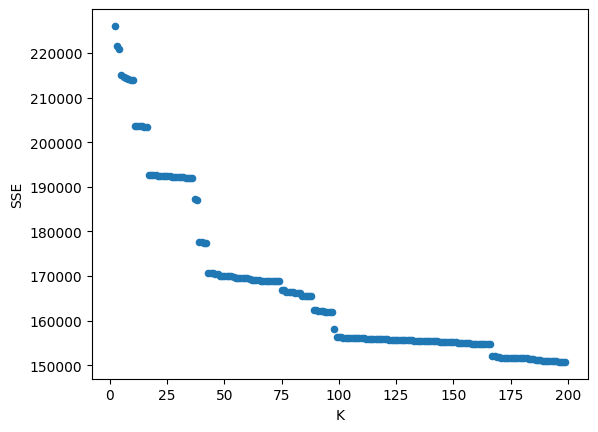

In [34]:
min_clusters = 2 #min number of clusters to try
max_clusters = 200 #max number of clusters to try

path = "./dataset/sse_df_"+str(min_clusters)+"-"+str(max_clusters)+".csv"

sse_df = None

if (os.path.exists(path)):
    sse_df = pd.read_csv(path)
else:
    sse_df = pd.DataFrame(columns=["K", "SSE"])
    for num_curr_clusters in range(2, max_clusters): # try differen number of clusters
        #compute the cluster
        labels = AgglomerativeClustering(n_clusters = num_curr_clusters, affinity='euclidean', linkage='ward').fit_predict(df)
        #print("trying with", num_curr_clusters, "clusters")

        
        global_sse = 0 #the sse for the clustering with this number of clusters

        for i in range(num_curr_clusters): # for each cluster
            indexes = np.nonzero(labels==i)[0] # indexes where the label is equal to the current cluster 
            points_in_cluster = np.take(transformed_array, indexes, axis=0 ) # points in the cluster
            #print("in the cluster", i, "there are ", points_in_cluster.shape, "points")
            centroid = np.mean(points_in_cluster, axis=0)
            #print("centroid shape", centroid.shape)

            # calculate the sse for the single cluster
            current_sse = 0
            for p in points_in_cluster:
                current_sse += np.square( np.linalg.norm( np.subtract(p, centroid)))

            global_sse += current_sse
            
        sse_df = pd.concat( [sse_df , pd.DataFrame({"K" : [num_curr_clusters], "SSE": [global_sse] }) ], axis=0)

    sse_df = sse_df.astype({"K" : int , "SSE" : float})
    #sse_df.to_csv(path)


sse_df = sse_df.astype({"K" : int , "SSE" : float})

sse_df.plot.scatter(x = "K", y="SSE")



As expected, the biggest SSE decreasing is between O and 40. From 40 to 200 the SSE of course still decreases but slower compered to the number of cluster added.

We decide to set K=40

In [35]:
K = 40

labels = AgglomerativeClustering(n_clusters = K, affinity='euclidean', linkage='ward').fit_predict(df)

cluster_size_df = pd.DataFrame({
    "cluster_number" : [i for i in range(K)], 
    "cluster_size" : [len(np.nonzero(labels==i)[0]) for i in range(K)] })

cluster_size_df.head(K)

,cluster_number,cluster_size
0,0,501
1,1,128
2,2,6
3,3,108
4,4,20
5,5,36
6,6,17
7,7,643
8,8,10
9,9,8


As you can see, a lot of cluster have less than 10 element inside, but since even with only K=10 (not shown) an high percentage of clusters have less than 10 elemet inside, we decided to keep the value K=40 based on the SSE analysis

We also noted that the biggest part of the users are in the same cluster (cluster 36), we are confident that this cluster represents the standard type of user with very few interactions